# Integration of scRNA-seq data from Parkinson's disease studies

## Description

* This notebook covers  functions to integrate data from single nuclei RNA-seq (snRNA-seq) data from two studies [Agarwal_2020](https://pubmed.ncbi.nlm.nih.gov/32826893/) and [Kamath_2022](https://pubmed.ncbi.nlm.nih.gov/35513515/).
* It runs the following steps:
    * Load files produced by `01_data_management.ipynb`
    * QC filtering
    * Normalization
    * Scaling
    * Dim. reduction
    * Unsupervised clustering
    * Harmony batch correction
    * Saves h5ad for script `03_cell_type_labeling.ipynb`
* It compares results with vs. without batch correction using `Harmony`.

In [1]:
### External modules
import warnings
import os
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import logging
import sys
import seaborn as sns
import numpy as np
import zarr ### tested with zarr==2.18.7 and dask==2025.4.0

import io
import requests

### Internal modules
sys.path.append(os.path.expanduser("~/sc_and_spatial_parkinson/src/python"))
from utils.reformat_to_adata import convert_zarr_to_adata

### Logs and warning settings
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(name)s %(levelname)s:\n%(message)s")
logger = logging.getLogger(__name__)

/Users/jdime/venv_bioinfo/lib/python3.13/site-packages/anndata/utils.py:434: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


## Define inputs/outputs.

In [2]:
### Sample metadata
google_id_sample_metadata = "1761mSSr1jY_SkJ9UvZ4Zyf1G39B9y0CGnzlItFEF9iY"

### base indir zarr files
in_zarr = os.path.expanduser('~/sc_and_spatial_parkinson/data/zarr')
in_h5ad = os.path.expanduser('~/sc_and_spatial_parkinson/data/adata')

### Studies
study_names = ['Agarwal_NatCommun_2020_32826893','Kamath_NatNeurosci_2022_35513515']

## Load zarr into AnnData
Optionally can uncomment `sc.read_h5ad()` to use `h5ad` instead of `zarr` format

In [3]:
conc_adatas = []
adatas_dic = {}
for study_name in study_names:
    logger.info((f"Read: {study_name}"))
    adata = convert_zarr_to_adata(os.path.join(in_zarr, study_name + '.zarr'))
    # adata = sc.read_h5ad(os.path.join(in_h5ad, study_name + '.h5ad'))
    
    logger.info((f"Read: {adata}"))
    conc_adatas.append(adata)
    adatas_dic[study_name] = adata

adata = conc_adatas[0].concatenate(conc_adatas[1:], join="inner", index_unique=None)
adata_original_shape = adata.shape
logger.info((f"Concatenated: {adata}"))

2025-06-22 22:11:12,966 __main__ INFO:
Read: Agarwal_NatCommun_2020_32826893
2025-06-22 22:11:14,264 __main__ INFO:
Read: AnnData object with n_obs × n_vars = 18120 × 33694
    obs: 'barcode', 'study_name', 'sample_name', 'sample_source', 'sample_organism', 'sample_tissue_region', 'donor_gender', 'donor_age_years', 'cause_of_death', 'main_cell_type', 'cell_type', 'Nurr_status'
    var: 'gene'
2025-06-22 22:11:14,266 __main__ INFO:
Read: Kamath_NatNeurosci_2022_35513515
2025-06-22 22:11:20,814 __main__ INFO:
Read: AnnData object with n_obs × n_vars = 103691 × 34010
    obs: 'barcode', 'study_name', 'sample_name', 'sample_source', 'sample_organism', 'sample_tissue_region', 'donor_gender', 'donor_age_years', 'cause_of_death', 'main_cell_type', 'cell_type', 'Nurr_status'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'gene'
    obsm: 'X_umap'
2025-06-22 22:11:37,513 __main__ INFO:
Concatenated: AnnData object with n

## Quality control
In the violin and scatter plots below, we can see that:
- The two studies have similar n_gene coverage, although the Agarwal_2020 is sequenced shallower than the Kamath_2022
    - Since this is publicly available data not much can be done to increase Agarwal_2020 sequencing depth
    - For internal datasets, one could check biological findings and liaise with the experimental team for deeper sequencing
- The Kamath_2022 study is already filtered by mito > 10% (as indicated in the paper); whereas the Agarwal_2020 study is unfiltered by mito
    - Since these are single `nuclei` datasets, we don't expect mito > 5-10% (single cell can be allowed as high as 25%, depending on tissue/cell type).
    - The scatter plot shows that most cells with very high mito % in Agarwal_2020 have very low number of reads, which is another indicator of poor QC for those cells.
    - `ACTION:` for consistency in the analysis, below we filter out cells with `pct_counts_mt > 10%, n_genes < 100` and genes with `n_cells < 4`
- Studies have similar ribosomal protein gene expression (<5%); thus this is not and issue.

`NOTE:` For studies with multiple experimental batches (e.g. from different labs), QC should be performed for each sample individually.

### Mito %, Ribo%, n_cells and n_genes

In [4]:
adata.var["mt"]   = adata.var['gene-0'].str.startswith("MT-") | adata.var['gene-1'].str.startswith("MT-")
adata.var["ribo"] = adata.var['gene-0'].str.startswith(("RPS", "RPL")) | adata.var['gene-1'].str.startswith(("RPS", "RPL"))
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2025-06-22 22:27:19,859 __main__ INFO:
QC: Agarwal_NatCommun_2020_32826893


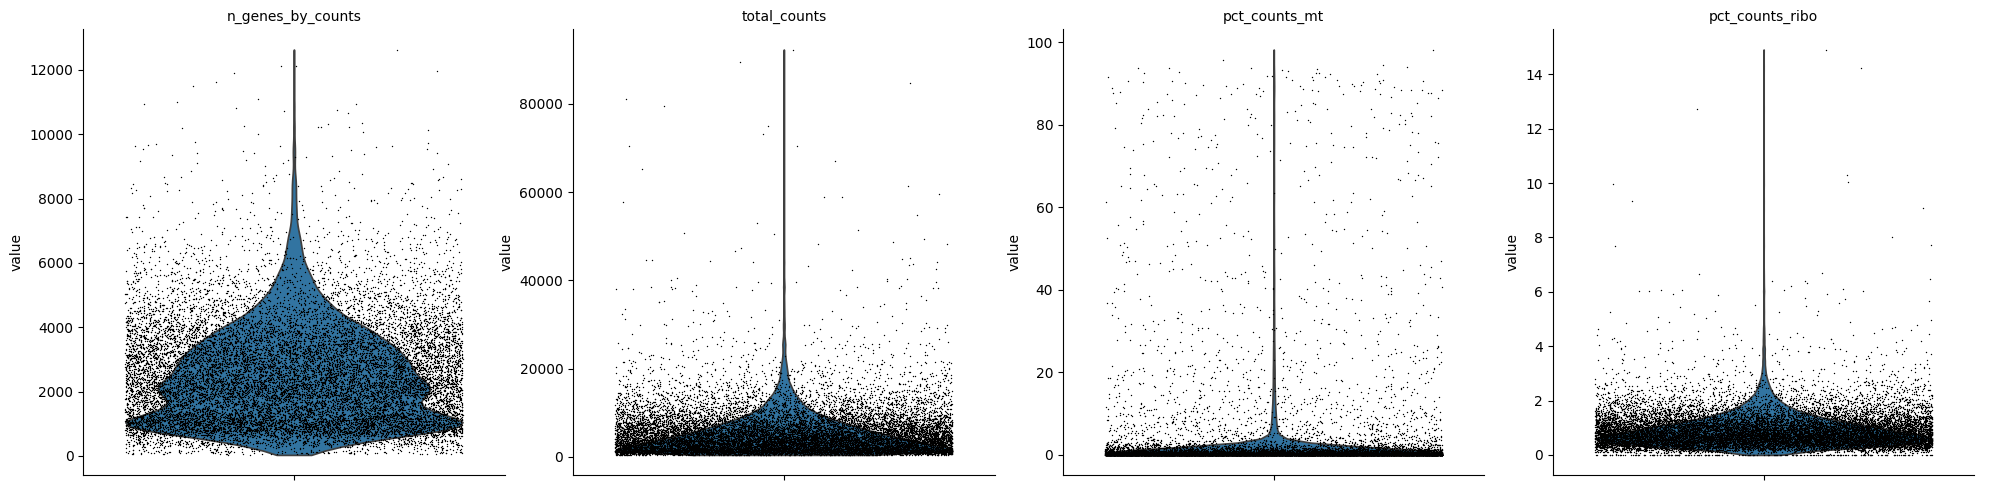

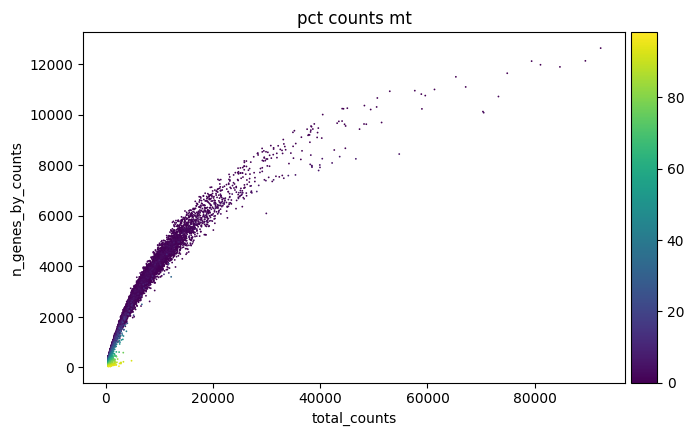

2025-06-22 22:27:21,775 __main__ INFO:
QC: Kamath_NatNeurosci_2022_35513515


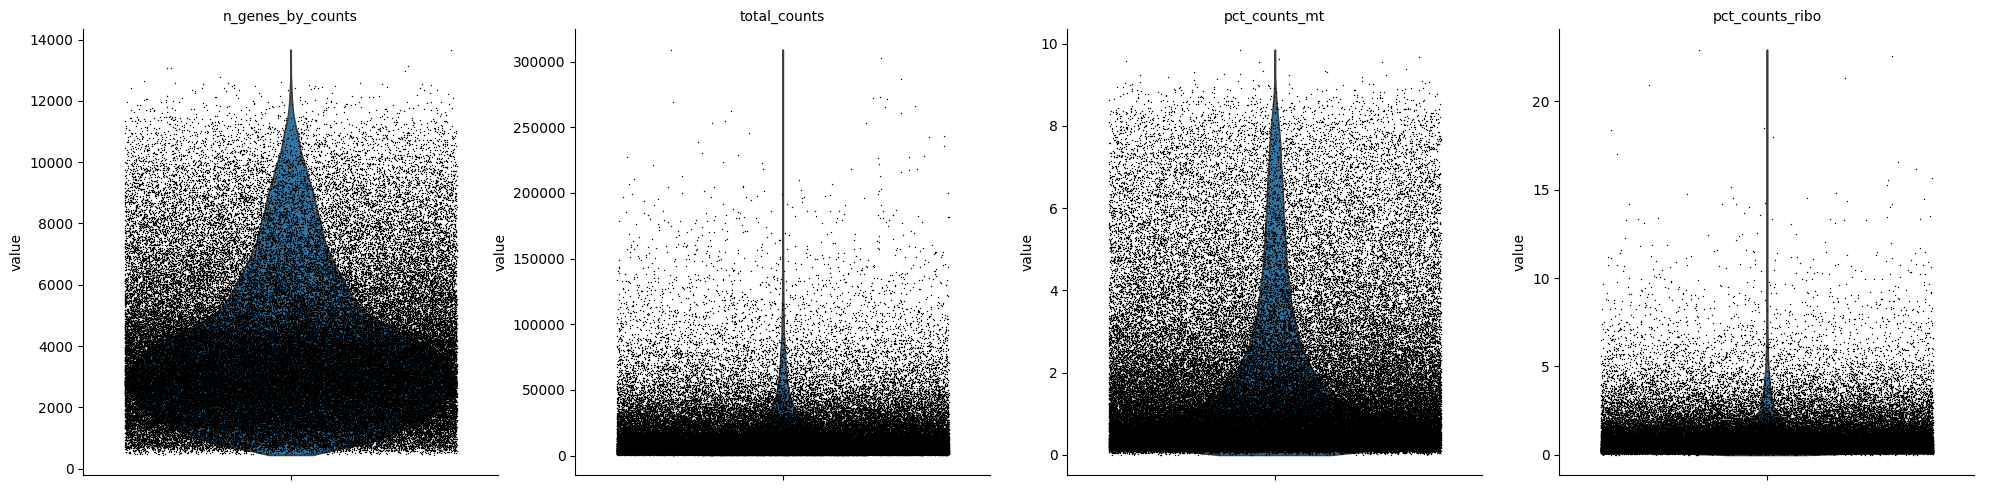

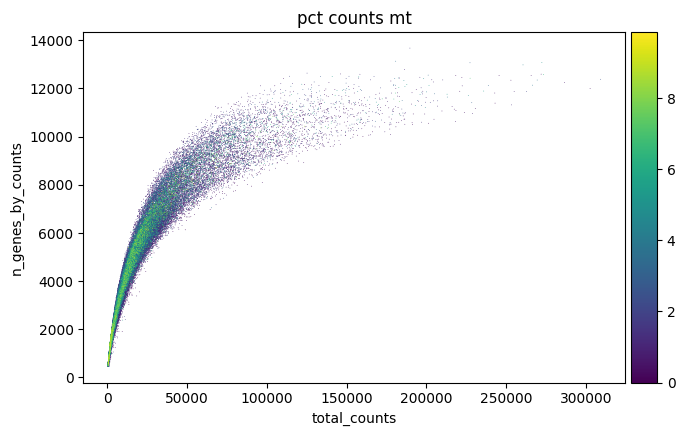

In [5]:
for study_name in study_names:
    logger.info((f"QC: {study_name}"))
    adata_study = adata[adata.obs['study_name'] == study_name]
    sc.pl.violin(
        adata_study,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
        jitter=0.4,
        multi_panel=True,
    )
    sc.pl.scatter(adata_study, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

#### Apply Mito %, n_cells and n_genes QC filters

In [6]:
# adata_before_filters = adata.copy() ### backup before filtering cells
# adata = adata_before_filters.copy()

sc.pp.filter_cells(adata, min_genes=100, inplace=True)
sc.pp.filter_genes(adata, min_cells=3, inplace=True)
filter_mt = adata.obs['pct_counts_mt'] < 10
logger.info((f"QC pass mt: {filter_mt.value_counts()}"))
adata = adata[filter_mt]
adata_filtered_shape = adata.shape

2025-06-22 22:28:35,170 __main__ INFO:
QC pass mt: pct_counts_mt
True     120955
False       803
Name: count, dtype: int64


In [7]:
logger.info((f"Original adata (n_cells × n_genes): {adata_original_shape}"))
logger.info((f"Filtered adata (n_cells × n_genes): {adata_filtered_shape}"))
logger.info((f"Removed (n_cells={adata_original_shape[0] - adata_filtered_shape[0]}, \
n_genes={adata_original_shape[1] - adata_filtered_shape[1]}"))

2025-06-22 22:28:35,288 __main__ INFO:
Original adata (n_cells × n_genes): (121811, 29546)
2025-06-22 22:28:35,291 __main__ INFO:
Filtered adata (n_cells × n_genes): (120955, 27960)
2025-06-22 22:28:35,292 __main__ INFO:
Removed (n_cells=856, n_genes=1586


#### Filtered Agarwal_2020 plots

2025-06-22 22:30:07,466 __main__ INFO:
QC filtered out: Agarwal_NatCommun_2020_32826893


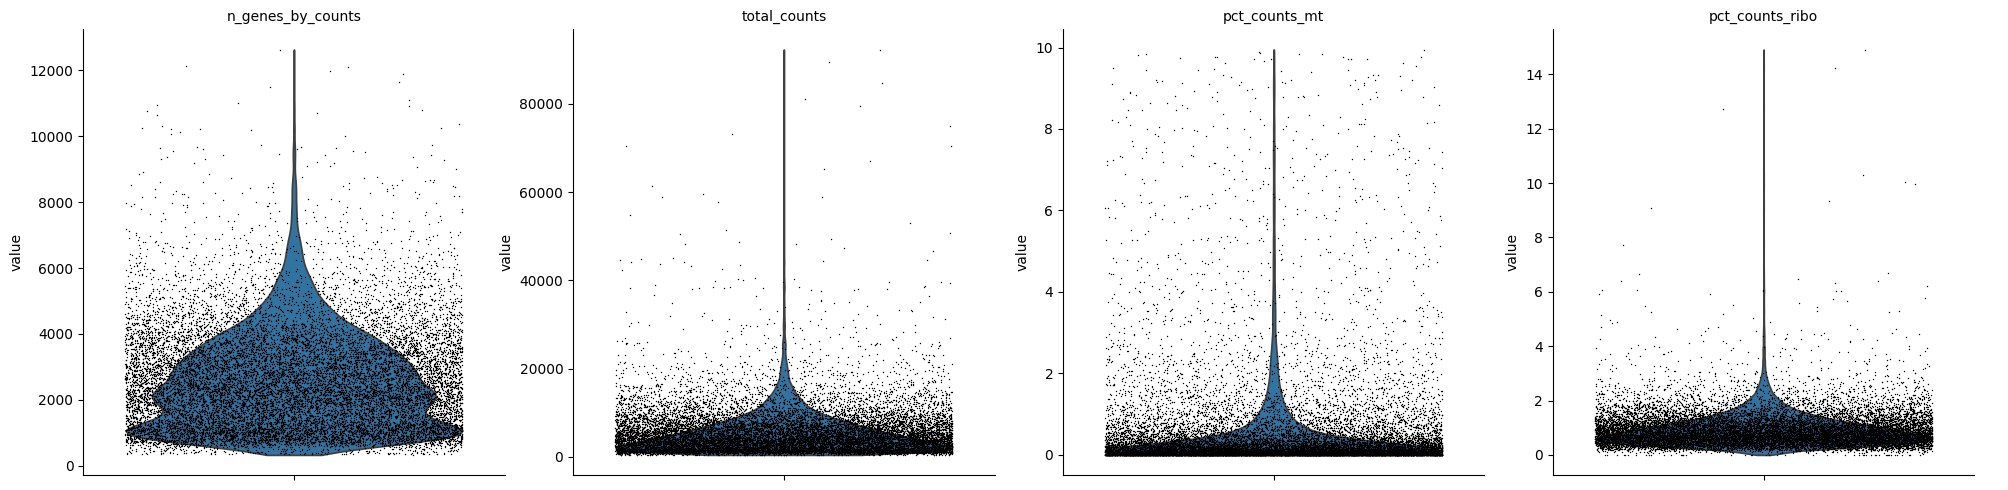

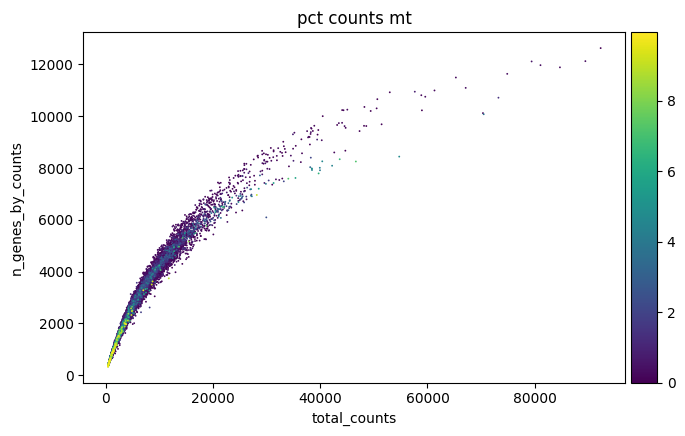

In [9]:
study_name = 'Agarwal_NatCommun_2020_32826893'
logger.info((f"QC filtered out: {study_name}"))
adata_study = adata[adata.obs['study_name'] == study_name]
sc.pl.violin(
    adata_study,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata_study, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### Doublet detection

- Using Scanpy's implementation of Scrublet
- `IMPORTANT:` Scrublet metrics depend on per-sample sequencing depth, then one must use `batch_key="sample_name"`
- Scrublet detected doublets in these studies for:
    - Agarwal_2020 = 0.6% of cells
    - Kamath_2022 = 1.8% of cells

In [10]:
sc.pp.scrublet(adata, batch_key="sample_name")
logger.info((f"Doublet prediction: {adata.obs[['study_name','predicted_doublet']].value_counts()}"))

2025-06-22 22:37:37,632 __main__ INFO:
Doublet prediction: study_name                        predicted_doublet
Kamath_NatNeurosci_2022_35513515  False                101868
Agarwal_NatCommun_2020_32826893   False                 17165
Kamath_NatNeurosci_2022_35513515  True                   1823
Agarwal_NatCommun_2020_32826893   True                     99
Name: count, dtype: int64


## Normalization
- Using `sc.pp.normalize_total(..., target_sum=1e6)` to have a fixed target value in case this datasets are integrated with others in the future. Alternatively, the default is to use the median of total counts only in the adata processed here.

In [11]:
adata.layers["counts"] = adata.X.copy() # Backup of raw counts (integers)
sc.pp.normalize_total(adata=adata, target_sum=1e6)
sc.pp.log1p(adata)

## Feature selection
- Using Seurat v3 flavor as it was designed to deal with multi-mode and different scRNA-seq technologies
- Again, make sure to use `use batch_key="sample_name"`

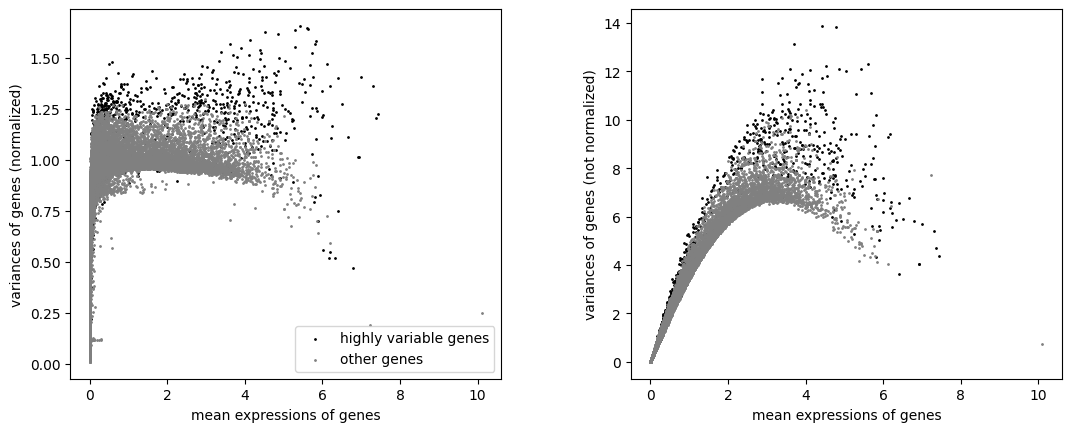

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample_name", flavor="seurat_v3")
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction using PCA
- Typically between 20 and 50 PCs capture most of the variance
    - For these two concatenated studies, we can see that after 30 PCs there is little variance accumulated
- Here tried a grid search, testing scaling `sc.tl.pca()` before PCA and zero centering in `sc.pp.scale()` and `sc.tl.pca()`.
    - This was because there isn't a community consensus about whether one should scale data or not. It should be evaluated on a case by case basis (https://github.com/scverse/scanpy/issues/2164)
    - A visual inspection of the UMAP plots showed that option 4 (with scale and no zero center) gave better outcome.
- Mitochondrial protein gene expression

## Save/read checkpoint (optional)

In [13]:
# adata.write(os.path.join(in_h5ad, "adata_before_pca.h5ad"), compression='gzip')
# adata = sc.read_h5ad(os.path.join(in_h5ad, "adata_before_pca.h5ad"))

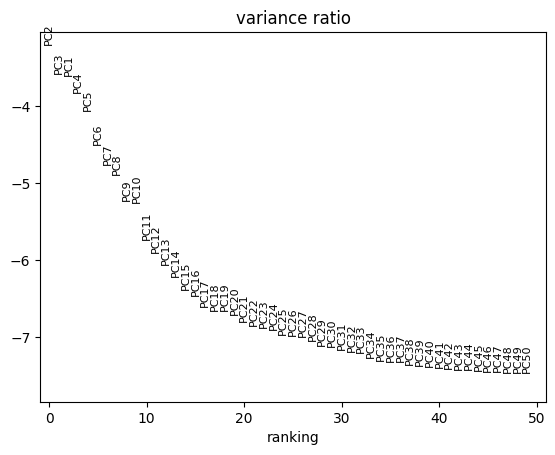

In [14]:
### Grid search of scaling (yes/no) and zero centering (yes/no)
### Commented options 1 to 3, because option 4 showed better batch correction from UMAP visual inspection

### 1) No scale, zero_center=True
# sc.tl.pca(adata, n_comps=50, zero_center=True)
# sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

### 2) No scale, zero_center=False
# sc.tl.pca(adata, n_comps=50, zero_center=False)
# sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

### 3) Scale, zero_center=True
# sc.pp.scale(adata, zero_center=True)
# sc.tl.pca(adata, n_comps=50, zero_center=True)
# sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

### 4) Scale, zero_center=False
sc.pp.scale(adata, zero_center=False)
sc.tl.pca(adata, n_comps=50, zero_center=False)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

... storing 'study_name' as categorical
... storing 'sample_name' as categorical
... storing 'sample_tissue_region' as categorical
... storing 'donor_gender' as categorical
... storing 'donor_age_years' as categorical
... storing 'cause_of_death' as categorical
... storing 'main_cell_type' as categorical
... storing 'cell_type' as categorical
... storing 'Nurr_status' as categorical
... storing 'batch' as categorical
... storing 'study_name_abv' as categorical


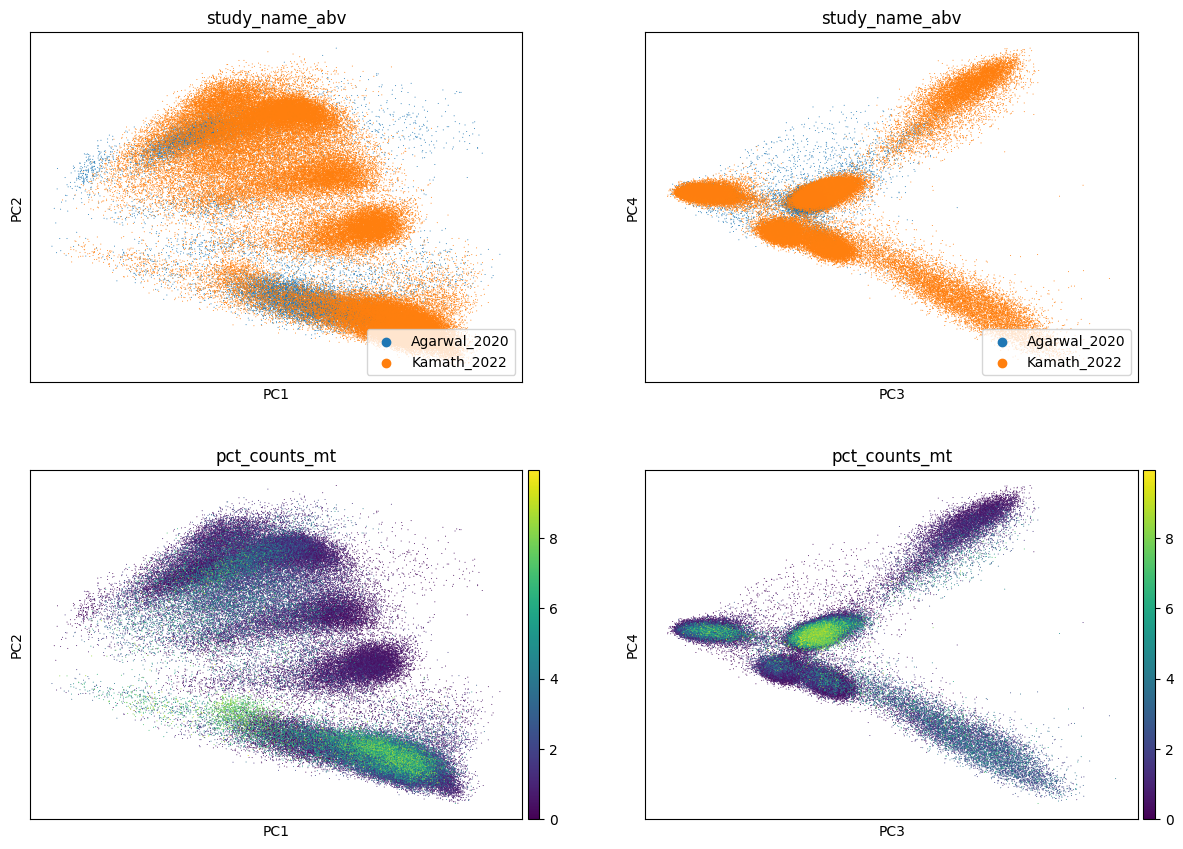

In [15]:
adata.obs['study_name_abv'] = adata.obs['study_name'].str.split("_").str[0] + "_" + adata.obs['study_name'].str.split("_").str[2]
sc.pl.pca(
    adata,
    color=["study_name_abv", "study_name_abv", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
    legend_loc=4,
)

## UMAP plot without batch correction

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata=adata, key_added="umap_no_batch_corr")
adata.obs["umap_no_batch_corr_1"] = list(pd.DataFrame(adata.obsm["umap_no_batch_corr"])[0]) ## no-batch corrected
adata.obs["umap_no_batch_corr_2"] = list(pd.DataFrame(adata.obsm["umap_no_batch_corr"])[1]) ## no-batch corrected

## Unsupervised clustering
- Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets.
- A `resolution=0.32` as used as a tradeoff number (8) of cell types identified by Kamath et al. 2022 and 2x number of clusters (16), for mapping between unsupervised clusters vs. author labels.

In [17]:
sc.tl.leiden(adata, flavor="igraph", key_added='leiden', n_iterations=2, resolution=0.32)

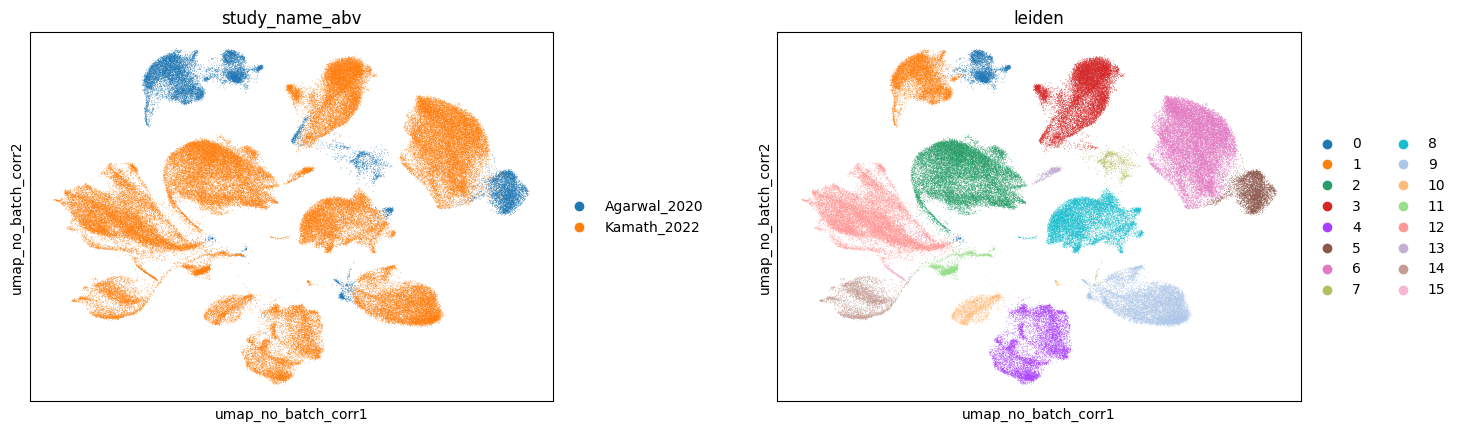

In [18]:
sc.pl.embedding(adata, basis='umap_no_batch_corr', color=["study_name_abv","leiden"], ncols=2, wspace=0.3)

## Harmony batch correction
- Harmony should be run after performing PCA but before computing the neighbor graph

In [20]:
sc.pp.pca(adata)
sce.pp.harmony_integrate(adata=adata, key="sample_name")

2025-06-22 23:08:59,150 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-22 23:08:59,150 harmonypy INFO:
Computing initial centroids with sklearn.KMeans...
2025-06-22 23:09:23,387 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-22 23:09:23,387 harmonypy INFO:
sklearn.KMeans initialization complete.
2025-06-22 23:09:24,536 - harmonypy - INFO - Iteration 1 of 10
2025-06-22 23:09:24,536 harmonypy INFO:
Iteration 1 of 10
2025-06-22 23:11:00,013 - harmonypy - INFO - Iteration 2 of 10
2025-06-22 23:11:00,013 harmonypy INFO:
Iteration 2 of 10
2025-06-22 23:12:35,588 - harmonypy - INFO - Iteration 3 of 10
2025-06-22 23:12:35,588 harmonypy INFO:
Iteration 3 of 10
2025-06-22 23:14:12,475 - harmonypy - INFO - Iteration 4 of 10
2025-06-22 23:14:12,475 harmonypy INFO:
Iteration 4 of 10
2025-06-22 23:15:47,680 - harmonypy - INFO - Iteration 5 of 10
2025-06-22 23:15:47,680 harmonypy INFO:
Iteration 5 of 10
2025-06-22 23:17:23,236 - harmonypy - INFO 

In [ ]:
sc.pp.neighbors(adata, use_rep="X_pca_harmony", key_added="neighbours_sample")
adata.obsm['X_umap_harmony'] = sc.tl.umap(
    adata, neighbors_key="neighbours_sample", copy=True
).obsm['X_umap']
### Add UMAP coordinates to obs for use with Plotly
adata.obs["umap_harmony_1"] = list(pd.DataFrame(adata.obsm["X_umap_harmony"])[0])
adata.obs["umap_harmony_2"] = list(pd.DataFrame(adata.obsm["X_umap_harmony"])[1])

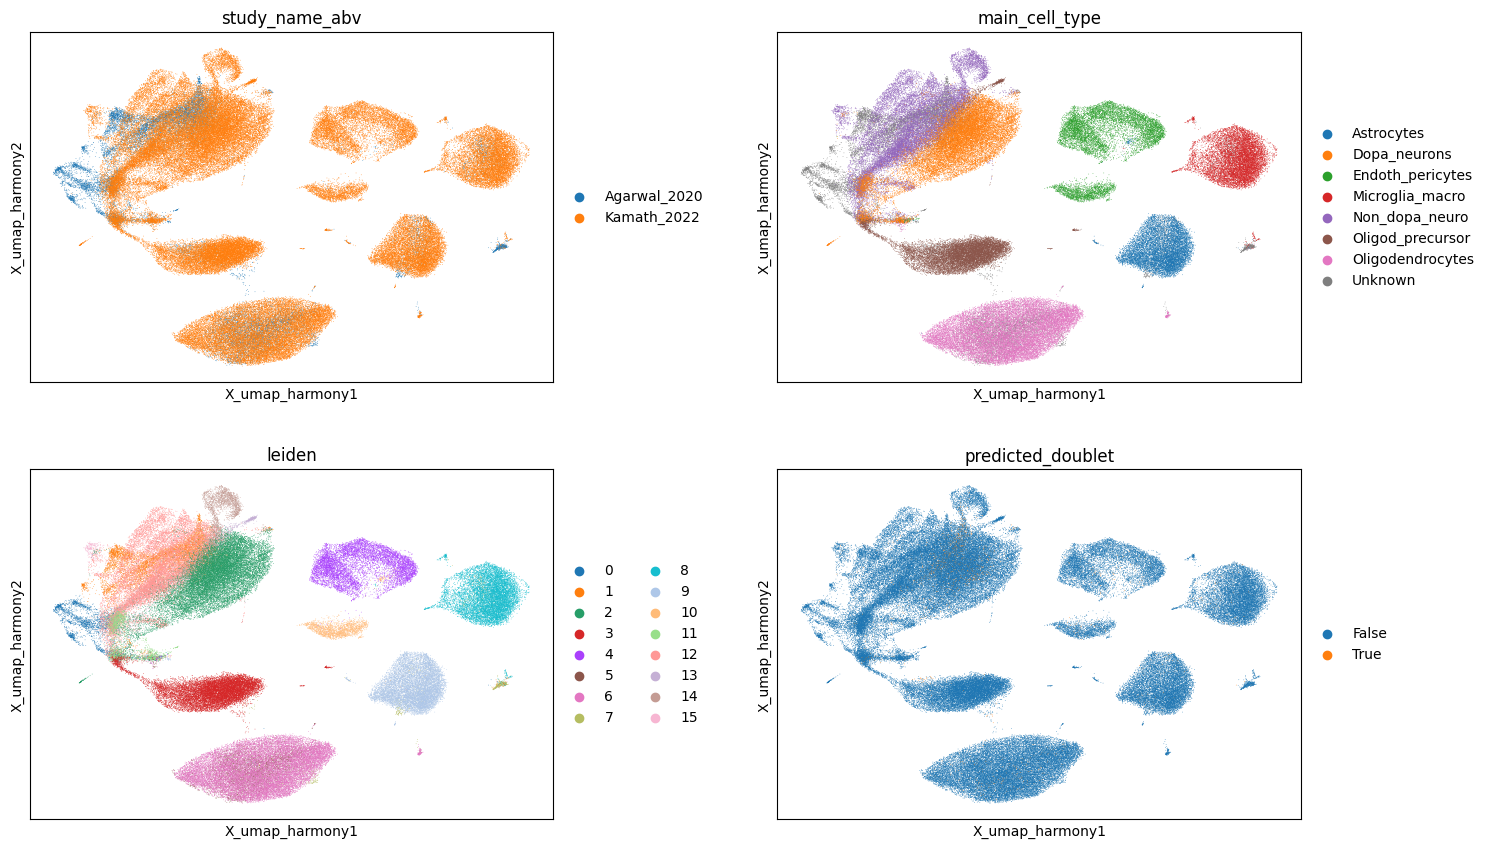

In [31]:
sc.pl.embedding(adata, basis='X_umap_harmony', color=["study_name_abv","main_cell_type","leiden","predicted_doublet"], wspace=0.3, ncols=2)

## Save checkpoint (needed for script `03_cell_type_labeling.ipynb`)

In [25]:
adata.write(os.path.join(in_h5ad, "adata_after_harmony.h5ad"), compression='gzip')

## End of script